In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import itertools
from statistical_functions import preprocess, test_is_I1, test_is_tradable
import matplotlib.pyplot as plt

C:\Users\andy5\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from arch.unitroot import ADF
from scipy import odr

def TLS_regresssion(stock_1, stock_2):
    def f(B, x):
        '''Linear function y = m*x + b'''
        # B is a vector of the parameters.
        # x is an array of the current x values.
        # x is in the same format as the x passed to Data or RealData.
        # Return an array in the same format as y passed to Data or RealData.
        return B[0]*x + B[1]

    linear_model = odr.Model(f)
    used_data = odr.Data(stock_1, stock_2)
    TLS_regression_model = odr.ODR(used_data, linear_model, beta0=[1., 2.])
    result = TLS_regression_model.run()
    return result

In [3]:
data = pd.read_csv("finance_data.csv")
data.columns = [
    'code', 'name', 'date', 'price'
]
data.date = data.date.apply(lambda x: datetime.strptime(str(x), "%Y%m%d"))
data['year'] = data.date.apply(lambda x: x.year)
data['month'] = data.date.apply(lambda x: x.month)
data['week'] = data.date.apply(lambda x: x.week)
data['dayofweek'] = data.date.apply(lambda x: x.dayofweek)
data.sort_values('date', inplace=True)

timeframe = data[['year', 'month', 'week']].drop_duplicates()
timeframe.reset_index(drop=True, inplace=True)

# create dataframe of date for available data
# it will be used to check whether stocks containing enough data
# before further cointegration testing
# trade off between speed and more possible pairs
date = pd.DataFrame(data.date.unique(), columns=['date'])
date['year'] = date.date.apply(lambda x: x.year)
date['month'] = date.date.apply(lambda x: x.month)
date['week'] = date.date.apply(lambda x: x.week)
date['dayofweek'] = date.date.apply(lambda x: x.dayofweek)
trailing_windows = 52
ASR_threshold = 1.5
take_profit_sigma_num = 0.5

data.head()

,code,name,date,price,year,month,week,dayofweek
0,2801,彰銀,2000-01-04,10.89,2000,1,1,1
11,2849,安泰銀,2000-01-04,11.12,2000,1,1,1
10,2845,遠東銀,2000-01-04,4.38,2000,1,1,1
9,2838,聯邦銀,2000-01-04,5.57,2000,1,1,1
7,2834,臺企銀,2000-01-04,11.09,2000,1,1,1


In [4]:
trade_result = pd.read_csv('trade_result_finance_ASR_3_Num_30_ADF_3.csv')
trade_result.reason.unique()

array(['cointegration_invalid', 'stop_loss', 'reversion', 'take_profit'], dtype=object)

In [5]:
temp_result = trade_result[trade_result.reason == 'cointegration_invalid']
temp_result.head()

,Unnamed: 0,ADF_statistic_in,ADF_statistic_out,ASR_in,ASR_out,PS_in,PS_out,date_in,date_out,hedge_ratio_in,...,spread_in,spread_out,stock_1_in,stock_1_log_in,stock_1_log_out,stock_1_out,stock_2_in,stock_2_log_in,stock_2_log_out,stock_2_out
0,"(2812, 2816)",-4.066761,NaN,4.096069,NaN,4.500381,NaN,2000-12-11,2000-12-18,1.236138,...,0.302464,NaN,3.41,1.226712,NaN,3.39,78.27,4.360164,NaN,98.89
3,"(2812, 2836)",-3.290617,NaN,3.644844,NaN,1.456242,NaN,2001-02-05,2001-02-12,1.033131,...,0.294582,NaN,4.51,1.506297,NaN,4.42,6.03,1.796747,NaN,6.03
4,"(2834, 2836)",-3.045359,NaN,3.138561,NaN,1.053250,NaN,2001-02-05,2001-02-12,1.972304,...,0.366308,NaN,10.59,2.359910,NaN,10.26,6.03,1.796747,NaN,6.03
5,"(2834, 2845)",-3.618547,NaN,3.692538,NaN,2.243455,NaN,2000-12-26,2001-03-12,1.929003,...,0.329289,NaN,8.66,2.158715,NaN,9.36,2.68,0.985817,NaN,3.25
6,"(2832, 2834)",-4.053082,NaN,3.530174,NaN,3.774629,NaN,2001-04-02,2001-05-02,0.640835,...,-0.187532,NaN,3.63,1.289233,NaN,3.34,8.66,2.158715,NaN,8.08


In [6]:
no_cointergration_counter = 0
ok_counter = 0
len_not_match_counter = 0

for i in range(len(temp_result)):
    pair = tuple(list(map(lambda x: int(x), temp_result['Unnamed: 0'].iloc[i][1:11].split(', '))))
    target = date[date.date == temp_result.date_out.iloc[i]]
    
    index = timeframe[
        (timeframe.year == target.year.values[0]) &
        (timeframe.month == target.month.values[0]) & 
        (timeframe.week == target.week.values[0])
    ]
    
    current_step = index.index[0]
    timeframe_for_model = timeframe.iloc[current_step-trailing_windows: current_step]
    
    start_date = date[
        (date.year == timeframe_for_model.iloc[0]['year']) &
        (date.month == timeframe_for_model.iloc[0]['month']) &
        (date.week == timeframe_for_model.iloc[0]['week'])
    ].iloc[0]['date']

    end_date = date[
        (date.year == timeframe_for_model.iloc[-1]['year']) &
        (date.month == timeframe_for_model.iloc[-1]['month']) &
        (date.week == timeframe_for_model.iloc[-1]['week'])
    ].iloc[-1]['date']

    date_for_model = date[(date.date >= start_date) & (date.date<=end_date)]

    data_for_model = data[data.date.isin(date_for_model.date)]

    stock_1 = data_for_model[data_for_model.code == pair[0]]
    stock_2 = data_for_model[data_for_model.code == pair[1]]
    if len(stock_1) == len(stock_2) == len(date_for_model):
        temp_pair = test_is_tradable(stock_1.price, stock_2.price)
        if temp_pair is None:
            print('   no cointergration! ', pair, target.date.values[0])
            no_cointergration_counter += 1
        else:
            print('   ok', pair, target.date.values[0])
            ok_counter += 1
    else:
        print('   len not match! ', pair, target.date.values[0])
        len_not_match_counter += 1

   no cointergration!  (2812, 2816) 2000-12-18T00:00:00.000000000
   no cointergration!  (2812, 2836) 2001-02-12T00:00:00.000000000
   no cointergration!  (2834, 2836) 2001-02-12T00:00:00.000000000
   no cointergration!  (2834, 2845) 2001-03-12T00:00:00.000000000
   no cointergration!  (2832, 2834) 2001-05-02T00:00:00.000000000
   no cointergration!  (2816, 2849) 2002-01-02T00:00:00.000000000
   no cointergration!  (2836, 2849) 2002-04-15T00:00:00.000000000
   no cointergration!  (2816, 2851) 2002-12-02T00:00:00.000000000
   no cointergration!  (2823, 2851) 2002-12-02T00:00:00.000000000
   no cointergration!  (2852, 2884) 2002-12-30T00:00:00.000000000
   no cointergration!  (2849, 2884) 2002-12-30T00:00:00.000000000
   no cointergration!  (2823, 2881) 2003-01-13T00:00:00.000000000
   no cointergration!  (2801, 2838) 2003-01-20T00:00:00.000000000
   no cointergration!  (2801, 2849) 2003-01-20T00:00:00.000000000
   no cointergration!  (2851, 2882) 2003-01-27T00:00:00.000000000
   no coin

   no cointergration!  (2809, 2849) 2007-07-09T00:00:00.000000000
   no cointergration!  (2884, 2890) 2007-07-16T00:00:00.000000000
   no cointergration!  (2836, 2882) 2007-07-16T00:00:00.000000000
   no cointergration!  (2823, 2838) 2007-07-23T00:00:00.000000000
   no cointergration!  (2820, 2884) 2007-07-23T00:00:00.000000000
   no cointergration!  (2834, 2849) 2007-07-30T00:00:00.000000000
   no cointergration!  (2881, 2889) 2007-08-01T00:00:00.000000000
   no cointergration!  (2801, 2823) 2007-08-13T00:00:00.000000000
   no cointergration!  (2836, 2891) 2007-08-13T00:00:00.000000000
   no cointergration!  (2881, 2889) 2007-09-03T00:00:00.000000000
   no cointergration!  (2850, 2888) 2007-09-10T00:00:00.000000000
   no cointergration!  (2850, 2882) 2007-09-10T00:00:00.000000000
   no cointergration!  (2823, 2838) 2007-09-26T00:00:00.000000000
   no cointergration!  (2820, 2892) 2007-10-15T00:00:00.000000000
   no cointergration!  (2890, 2892) 2007-10-22T00:00:00.000000000
   no coin

   no cointergration!  (2816, 2888) 2013-08-26T00:00:00.000000000
   no cointergration!  (2816, 2852) 2013-08-26T00:00:00.000000000
   no cointergration!  (2887, 2890) 2013-09-16T00:00:00.000000000
   no cointergration!  (2887, 2888) 2013-09-16T00:00:00.000000000
   no cointergration!  (2852, 2887) 2013-09-16T00:00:00.000000000
   no cointergration!  (2838, 5880) 2013-10-21T00:00:00.000000000
   no cointergration!  (2809, 2823) 2013-10-21T00:00:00.000000000
   no cointergration!  (2838, 2880) 2013-10-28T00:00:00.000000000
   no cointergration!  (2816, 2891) 2013-11-04T00:00:00.000000000
   no cointergration!  (2816, 2832) 2013-11-25T00:00:00.000000000
   no cointergration!  (2851, 2867) 2014-01-20T00:00:00.000000000
   no cointergration!  (2809, 2816) 2014-01-27T00:00:00.000000000
   no cointergration!  (2809, 2881) 2014-02-10T00:00:00.000000000
   no cointergration!  (2812, 2845) 2014-02-17T00:00:00.000000000
   no cointergration!  (2881, 2892) 2014-05-02T00:00:00.000000000
   no coin

   no cointergration!  (2885, 5880) 2018-03-05T00:00:00.000000000
   no cointergration!  (2885, 2888) 2018-03-05T00:00:00.000000000
   no cointergration!  (2838, 2889) 2018-03-05T00:00:00.000000000
   no cointergration!  (2820, 2838) 2018-03-26T00:00:00.000000000
   no cointergration!  (2845, 2885) 2018-04-02T00:00:00.000000000
   no cointergration!  (2820, 2885) 2018-04-23T00:00:00.000000000
   no cointergration!  (2832, 2834) 2018-04-30T00:00:00.000000000
   no cointergration!  (2820, 2882) 2018-04-30T00:00:00.000000000
   no cointergration!  (2834, 2888) 2018-05-02T00:00:00.000000000
   no cointergration!  (2812, 2881) 2018-05-07T00:00:00.000000000
   no cointergration!  (2834, 2890) 2018-05-21T00:00:00.000000000
   no cointergration!  (2849, 2851) 2018-07-16T00:00:00.000000000
   no cointergration!  (2849, 2850) 2018-07-23T00:00:00.000000000
   no cointergration!  (2838, 2851) 2018-08-20T00:00:00.000000000
   no cointergration!  (2834, 2850) 2018-08-27T00:00:00.000000000
   no coin

In [7]:
print('   ', len(temp_result) == no_cointergration_counter)
print('   ', len_not_match_counter)

    True
    0


# Random check

   no cointergration!


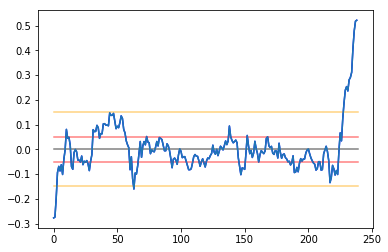

In [8]:
pair = (2812, 2816)
pair_date = '2000-12-18'
target = date[date.date == pair_date]

index = timeframe[
    (timeframe.year == target.year.values[0]) &
    (timeframe.month == target.month.values[0]) & 
    (timeframe.week == target.week.values[0])
]
# target

current_step = index.index[0]
timeframe_for_model = timeframe.iloc[current_step-trailing_windows: current_step]
# timeframe_for_model.tail(1)

start_date = date[
    (date.year == timeframe_for_model.iloc[0]['year']) &
    (date.month == timeframe_for_model.iloc[0]['month']) &
    (date.week == timeframe_for_model.iloc[0]['week'])
].iloc[0]['date']

end_date = date[
    (date.year == timeframe_for_model.iloc[-1]['year']) &
    (date.month == timeframe_for_model.iloc[-1]['month']) &
    (date.week == timeframe_for_model.iloc[-1]['week'])
].iloc[-1]['date']

date_for_model = date[(date.date >= start_date) & (date.date<=end_date)]

data_for_model = data[data.date.isin(date_for_model.date)]

timeframe_for_spread = timeframe.iloc[current_step]

date_for_spread = date[
    (date.year == timeframe_for_spread.year) &
    (date.month == timeframe_for_spread.month) &
    (date.week == timeframe_for_spread.week)
]

data_for_spread = data[
    (data.year == timeframe_for_spread.year) &
    (data.week == timeframe_for_spread.week)
]
data_for_spread = data_for_spread[data_for_spread.date == date_for_spread.date.iloc[0]]


stock_1 = data_for_model[data_for_model.code == pair[0]]
stock_2 = data_for_model[data_for_model.code == pair[1]]
if len(stock_1) == len(stock_2) == len(date_for_model):
    temp_pair = test_is_tradable(stock_1.price, stock_2.price)
    if temp_pair is None:
        print('   no cointergration!')
    else:
        print('   ok')
else:
    print('   len not match!', )

TLS_result = TLS_regresssion(np.log(stock_1.price.values), np.log(stock_2.price.values))
residual = np.log(stock_2.price.values) - TLS_result.beta[1] - TLS_result.beta[0]*np.log(stock_1.price.values)

stock_1 = data_for_spread[data_for_spread.code == pair[0]]
stock_2 = data_for_spread[data_for_spread.code == pair[1]]
new_spread = np.log(stock_2.price.values) - TLS_result.beta[1] - TLS_result.beta[0]*np.log(stock_1.price.values)
residual = np.append(residual, new_spread)

plt.plot(residual, c='blue')

plt.plot([np.std(residual)*ASR_threshold]*(len(residual)+1), c='orange', alpha=0.5)
plt.plot([-np.std(residual)*ASR_threshold]*(len(residual)+1), c='orange', alpha=0.5)
plt.plot([np.std(residual)*take_profit_sigma_num]*(len(residual)+1), c='red', alpha=0.5)
plt.plot([-np.std(residual)*take_profit_sigma_num]*(len(residual)+1), c='red', alpha=0.5)

plt.plot([0]*(len(residual)+1), c='grey')
plt.plot(residual);

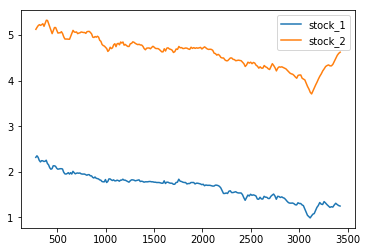

In [9]:
plt.plot(np.log(data_for_model[data_for_model.code == pair[0]].price), label='stock_1')
plt.plot(np.log(data_for_model[data_for_model.code == pair[1]].price), label='stock_2')
plt.legend();

In [10]:
# check whether spread is the same by differnt calculation, 
# if the exit type is 'cointegration_invalid' then the first item will be nan
# because it didn't be involved in the tradble pool
result = trade_result[trade_result['Unnamed: 0'] == str(pair)]
print("   ", result[result.date_out == pair_date]['spread_out'].values[0])
print("   ", new_spread[0])

    nan
    0.521925264555
